In [1]:
import gymnasium as gym
import numpy as np
from IPython.display import display, clear_output, Image
import time
from PIL import Image

map_name = '4x4'  # 4x4 or 8x8
n = int(map_name[0])

env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True, map_name=map_name)
env = env.unwrapped

def render_frame(env):
    frame = env.render()
    image = Image.fromarray(frame)
    display(image)

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


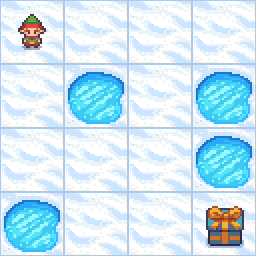

In [2]:
state, info = env.reset()
render_frame(env)

In [3]:
print(env.action_space)  # Discrete(4) -> 0:left, 1:down, 2:right, 3:up
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

desc = env.desc
desc

Discrete(4)


array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

In [4]:
rewards = [
    # for the interest of time, add a small penalty for walking around
    [-0.01 for _ in range(n)] for _ in range(n)
]
rewards[n-1][n-1] = 1000.0  # large reward for goal

In [5]:
from collections import defaultdict

di = [0, 1, 0, -1]
dj = [-1, 0, 1, 0]

states = set()  # (i, j) pairs that are indexed row, then column
for i in range(n):
    for j in range(n):
        states.add((i, j))

transitions = {}
for state in states:
    transitions[state] = {}  # (prob, next_state)

    if desc[state[0]][state[1]] in (b'H', b'G'):  # terminate on terminals
        # set all probs to 0, not mathematically consistent, oh well it works
        for action in range(4):
            transitions[state][action] = defaultdict(float)
            transitions[state][action][state] += 0
        continue

    for action in range(4):
        # the state transitions probs are already known from docs: 1/3 for intended 1/3 to slip to either adjacent tile
        transitions[state][action] = defaultdict(float)
        i = state[0]
        j = state[1]
        # intended
        intended_di = di[action]
        intended_dj = dj[action]
        next_state = (np.clip(i + intended_di, 0, n-1), np.clip(j + intended_dj, 0, n-1))  # clip to edges
        transitions[state][action][next_state] += 1/3  # accumulate probs (multiple actions may lead to same next state)
        # slips
        if intended_di == 0:
            slip_dj = 0
            # fst
            slip_di = -1
            slip_state = (np.clip(i + slip_di, 0, n-1), np.clip(j + slip_dj, 0, n-1))  # clip to edges
            transitions[state][action][slip_state] += 1/3
            # snd
            slip_di = 1
            slip_state = (np.clip(i + slip_di, 0, n-1), np.clip(j + slip_dj, 0, n-1))  # clip to edges
            transitions[state][action][slip_state] += 1/3
        elif intended_dj == 0:
            slip_di = 0
            # fst
            slip_dj = -1
            slip_state = (np.clip(i + slip_di, 0, n-1), np.clip(j + slip_dj, 0, n-1))  # clip to edges
            transitions[state][action][slip_state] += 1/3
            # snd
            slip_dj = 1
            slip_state = (np.clip(i + slip_di, 0, n-1), np.clip(j + slip_dj, 0, n-1))  # clip to edges
            transitions[state][action][slip_state] += 1/3
        else:
            assert False
        # shouldn't need to scale probs to sum to 1 now that it's properly accumulated

In [6]:
V_table = {state: 0.0 for state in states}

def V(s):  # current estimation
    return V_table[s]

def Psa(s, a):  # (default)dict for next states { s1: prob1, s2: prob2, ... }
    return transitions[s][a]

def R(s):  # immediate reward of a state, simpler than R(s, a) and should work the same
    return rewards[s[0]][s[1]]

def pi(s):
    # sum(prob * value) argmax across possible next states given each action
    best_action = None
    best_value = -2e9
    for a in range(4):
        ev = sum(prob * V(s_next) for s_next, prob in Psa(s, a).items())
        if ev > best_value:
            best_value = ev
            best_action = a
    return best_action

In [7]:
def value_iteration(gamma=0.99):  # gamma is discount factor
    eps = 1e-15

    global V_table
    V_table = {state: 0.0 for state in states}  # reset
    for iter in range(9999):
        # print(V_table)
        delta = 0  # max change across all V's of each state
        new_V_table = {}  # do a synchronous update (all at once) though async is fine too

        for s in states:
            mx = -2e9
            for a in range(4):
                ev = sum(prob * V(s_next) for s_next, prob in Psa(s, a).items())
                mx = max(mx, ev)
            new_V = R(s) + gamma * mx
            delta = max(delta, abs(new_V - V(s)))
            new_V_table[s] = new_V

        V_table.update(new_V_table)

        if delta < eps:
            print(f'iteration {iter}: max V change = {delta}')
            print(f'stopping, precision of <{eps} reached')
            break
        if iter % 9 == 0:
            print(f'iteration {iter}: max V change = {delta}')

In [8]:
value_iteration()

iteration 0: max V change = 1000.0
iteration 9: max V change = 26.864702882379675
iteration 18: max V change = 13.96289623089126
iteration 27: max V change = 10.945721950891482
iteration 36: max V change = 7.770372533457021
iteration 45: max V change = 5.411303544242855
iteration 54: max V change = 3.8445409204273915
iteration 63: max V change = 3.332569439947804
iteration 72: max V change = 2.708442050582164
iteration 81: max V change = 2.096408136422724
iteration 90: max V change = 1.5826760555377177
iteration 99: max V change = 1.1789151042663093
iteration 108: max V change = 0.8716811559797861
iteration 117: max V change = 0.6418468250983551
iteration 126: max V change = 0.47150608927381654
iteration 135: max V change = 0.3459117430364813
iteration 144: max V change = 0.25357956980354857
iteration 153: max V change = 0.18581277376887329
iteration 162: max V change = 0.13612245095305298
iteration 171: max V change = 0.09970634154149138
iteration 180: max V change = 0.073026562069912

In [9]:
V_table

{(0, 1): 493.4154455501812,
 (1, 2): 354.5453393029427,
 (2, 1): 636.422948023322,
 (0, 0): 536.2579797620382,
 (3, 1): 734.1268053175189,
 (1, 1): -0.01,
 (0, 3): 451.8329858739671,
 (2, 0): 585.5929641295362,
 (3, 0): -0.01,
 (2, 3): -0.01,
 (0, 2): 465.5551975671177,
 (3, 3): 1000.0,
 (2, 2): 608.8649215327088,
 (1, 0): 552.5385246033126,
 (3, 2): 854.1072324698226,
 (1, 3): -0.01}

In [10]:
# state from env.step is in the form of int in [0, n^2-1], convert it to tuple (i, j)
def int2state(i):
    return divmod(i, n)

int2state(11)

(2, 3)

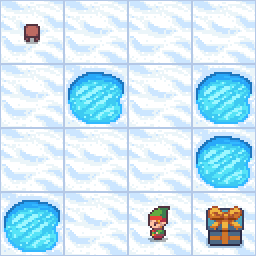

Step 12
Total coded rewards: -0.13
Episode finished with environment reward: 1.0


In [11]:
state, info = env.reset()
total_coded_rewards = 0
for step in range(999):
    clear_output(wait=True)
    render_frame(env)
    print(f"Step {step}")

    s = int2state(state)
    total_coded_rewards += R(s)
    total_coded_rewards = round(total_coded_rewards, 8)
    action = pi(s)
    state, reward, done, truncated, info = env.step(action)

    print(f'Total coded rewards: {total_coded_rewards}')
    if done or truncated:
        print(f"Episode finished with environment reward: {reward}")
        break
    time.sleep(.5)